# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("nuclear_charges")
forces[0]

<tf.Tensor: shape=(21, 3), dtype=float64, numpy=
array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52

In [6]:
from kgcnn.data.transform.scaler.force import EnergyForceExtensiveLabelScaler
scaler = EnergyForceExtensiveLabelScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.model.force import EnergyForceModel

In [8]:
model_config = {
    "model_energy":{
        "module_name": "kgcnn.literature.Schnet", 
        "class_name":"make_model", 
        "config":{
            "name": "Schnet",
            "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                       {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                       {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
            "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
            "make_distance": True, "expand_distance": True,
            "interaction_args": {"units": 128, "use_bias": True,
                                 "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
            "node_pooling_args": {"pooling_method": "sum"},
            "depth": 4,
            "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
            "verbose": 10,
            "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                         "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
            "output_embedding": "graph", "output_to_tensor": True,
            "use_output_mlp": True,
            "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                           "activation": ["kgcnn>shifted_softplus", "linear"]}}
    },
    "output_as_dict":True,
    "output_to_tensor":False,
    "output_squeeze_states":True,
}
model = EnergyForceModel(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [9]:
x_tensor = data.tensor(model_config["model_energy"]["config"]["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [10]:
test_out = model.predict(x_tensor)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

16/16 [==============================] - 6s 76ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [12]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": RaggedMeanAbsoluteError()},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights=[1, 20],
)

In [14]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 14s - loss: 18.9729 - energy_loss: 0.2492 - force_loss: 0.9362 - 14s/epoch - 2s/step
Epoch 2/1500
8/8 - 3s - loss: 18.9291 - energy_loss: 0.2126 - force_loss: 0.9358 - 3s/epoch - 341ms/step
Epoch 3/1500
8/8 - 2s - loss: 18.9023 - energy_loss: 0.2070 - force_loss: 0.9348 - 2s/epoch - 242ms/step
Epoch 4/1500
8/8 - 2s - loss: 18.8050 - energy_loss: 0.2334 - force_loss: 0.9286 - 2s/epoch - 236ms/step
Epoch 5/1500
8/8 - 2s - loss: 18.6889 - energy_loss: 0.4065 - force_loss: 0.9141 - 2s/epoch - 309ms/step
Epoch 6/1500
8/8 - 4s - loss: 18.3569 - energy_loss: 0.3620 - force_loss: 0.8997 - 4s/epoch - 504ms/step
Epoch 7/1500
8/8 - 1s - loss: 18.1333 - energy_loss: 0.6758 - force_loss: 0.8729 - 559ms/epoch - 70ms/step
Epoch 8/1500
8/8 - 1s - loss: 17.6005 - energy_loss: 0.6161 - force_loss: 0.8492 - 547ms/epoch - 68ms/step
Epoch 9/1500
8/8 - 1s - loss: 17.1591 - energy_loss: 0.9639 - force_loss: 0.8098 - 539ms/epoch - 67ms/step
Epoch 10/1500
8/8 - 1s - loss: 16.5441 - energy_loss: 1.1320 - 

Epoch 78/1500
8/8 - 4s - loss: 6.5645 - energy_loss: 0.7189 - force_loss: 0.2923 - 4s/epoch - 472ms/step
Epoch 79/1500
8/8 - 1s - loss: 6.6298 - energy_loss: 0.7610 - force_loss: 0.2934 - 546ms/epoch - 68ms/step
Epoch 80/1500
8/8 - 1s - loss: 6.6847 - energy_loss: 0.8013 - force_loss: 0.2942 - 547ms/epoch - 68ms/step
Epoch 81/1500
8/8 - 1s - loss: 6.6404 - energy_loss: 0.8029 - force_loss: 0.2919 - 549ms/epoch - 69ms/step
Epoch 82/1500
8/8 - 1s - loss: 6.6067 - energy_loss: 0.7289 - force_loss: 0.2939 - 540ms/epoch - 68ms/step
Epoch 83/1500
8/8 - 1s - loss: 6.7789 - energy_loss: 0.8103 - force_loss: 0.2984 - 563ms/epoch - 70ms/step
Epoch 84/1500
8/8 - 1s - loss: 7.4325 - energy_loss: 1.5203 - force_loss: 0.2956 - 559ms/epoch - 70ms/step
Epoch 85/1500
8/8 - 1s - loss: 7.1876 - energy_loss: 1.3601 - force_loss: 0.2914 - 556ms/epoch - 70ms/step
Epoch 86/1500
8/8 - 1s - loss: 7.1191 - energy_loss: 1.2443 - force_loss: 0.2937 - 564ms/epoch - 70ms/step
Epoch 87/1500
8/8 - 1s - loss: 7.3417 -

Epoch 155/1500
8/8 - 1s - loss: 4.4806 - energy_loss: 0.6976 - force_loss: 0.1892 - 1s/epoch - 149ms/step
Epoch 156/1500
8/8 - 1s - loss: 4.4493 - energy_loss: 0.7269 - force_loss: 0.1861 - 1s/epoch - 150ms/step
Epoch 157/1500
8/8 - 1s - loss: 4.4652 - energy_loss: 0.6983 - force_loss: 0.1883 - 1s/epoch - 149ms/step
Epoch 158/1500
8/8 - 1s - loss: 4.4254 - energy_loss: 0.7230 - force_loss: 0.1851 - 1s/epoch - 150ms/step
Epoch 159/1500
8/8 - 1s - loss: 4.3479 - energy_loss: 0.6950 - force_loss: 0.1826 - 1s/epoch - 147ms/step
Epoch 160/1500
8/8 - 1s - loss: 4.3910 - energy_loss: 0.6691 - force_loss: 0.1861 - 1s/epoch - 163ms/step
Epoch 161/1500
8/8 - 1s - loss: 4.4596 - energy_loss: 0.6698 - force_loss: 0.1895 - 1s/epoch - 173ms/step
Epoch 162/1500
8/8 - 1s - loss: 4.5304 - energy_loss: 0.6754 - force_loss: 0.1928 - 1s/epoch - 177ms/step
Epoch 163/1500
8/8 - 1s - loss: 4.7641 - energy_loss: 0.6558 - force_loss: 0.2054 - 1s/epoch - 166ms/step
Epoch 164/1500
8/8 - 1s - loss: 5.2027 - energ

Epoch 233/1500
8/8 - 1s - loss: 4.0309 - energy_loss: 0.6466 - force_loss: 0.1692 - 1s/epoch - 145ms/step
Epoch 234/1500
8/8 - 1s - loss: 3.6051 - energy_loss: 0.5640 - force_loss: 0.1521 - 1s/epoch - 138ms/step
Epoch 235/1500
8/8 - 1s - loss: 3.5656 - energy_loss: 0.5867 - force_loss: 0.1489 - 1s/epoch - 160ms/step
Epoch 236/1500
8/8 - 1s - loss: 3.6220 - energy_loss: 0.5982 - force_loss: 0.1512 - 1s/epoch - 174ms/step
Epoch 237/1500
8/8 - 1s - loss: 3.5133 - energy_loss: 0.5869 - force_loss: 0.1463 - 1s/epoch - 179ms/step
Epoch 238/1500
8/8 - 1s - loss: 3.5205 - energy_loss: 0.5513 - force_loss: 0.1485 - 1s/epoch - 172ms/step
Epoch 239/1500
8/8 - 2s - loss: 3.5668 - energy_loss: 0.5707 - force_loss: 0.1498 - 2s/epoch - 202ms/step
Epoch 240/1500
8/8 - 2s - loss: 3.5962 - energy_loss: 0.5942 - force_loss: 0.1501 - 2s/epoch - 198ms/step
Epoch 241/1500
8/8 - 2s - loss: 3.4472 - energy_loss: 0.5717 - force_loss: 0.1438 - 2s/epoch - 190ms/step
Epoch 242/1500
8/8 - 1s - loss: 3.4335 - energ

Epoch 311/1500
8/8 - 1s - loss: 3.3162 - energy_loss: 0.5438 - force_loss: 0.1386 - 1s/epoch - 134ms/step
Epoch 312/1500
8/8 - 1s - loss: 3.1428 - energy_loss: 0.5100 - force_loss: 0.1316 - 930ms/epoch - 116ms/step
Epoch 313/1500
8/8 - 1s - loss: 3.0382 - energy_loss: 0.5313 - force_loss: 0.1253 - 976ms/epoch - 122ms/step
Epoch 314/1500
8/8 - 1s - loss: 2.9985 - energy_loss: 0.5138 - force_loss: 0.1242 - 1s/epoch - 126ms/step
Epoch 315/1500
8/8 - 1s - loss: 3.0281 - energy_loss: 0.4869 - force_loss: 0.1271 - 1s/epoch - 136ms/step
Epoch 316/1500
8/8 - 1s - loss: 3.5232 - energy_loss: 0.9399 - force_loss: 0.1292 - 1s/epoch - 144ms/step
Epoch 317/1500
8/8 - 1s - loss: 3.4928 - energy_loss: 0.9253 - force_loss: 0.1284 - 1s/epoch - 159ms/step
Epoch 318/1500
8/8 - 1s - loss: 3.4264 - energy_loss: 0.8125 - force_loss: 0.1307 - 972ms/epoch - 122ms/step
Epoch 319/1500
8/8 - 1s - loss: 3.4834 - energy_loss: 0.7711 - force_loss: 0.1356 - 991ms/epoch - 124ms/step
Epoch 320/1500
8/8 - 1s - loss: 2.

Epoch 388/1500
8/8 - 1s - loss: 2.8574 - energy_loss: 0.5020 - force_loss: 0.1178 - 984ms/epoch - 123ms/step
Epoch 389/1500
8/8 - 1s - loss: 2.9658 - energy_loss: 0.4791 - force_loss: 0.1243 - 920ms/epoch - 115ms/step
Epoch 390/1500
8/8 - 1s - loss: 2.9143 - energy_loss: 0.4743 - force_loss: 0.1220 - 957ms/epoch - 120ms/step
Epoch 391/1500
8/8 - 1s - loss: 2.9251 - energy_loss: 0.4889 - force_loss: 0.1218 - 876ms/epoch - 109ms/step
Epoch 392/1500
8/8 - 1s - loss: 2.8829 - energy_loss: 0.4579 - force_loss: 0.1212 - 894ms/epoch - 112ms/step
Epoch 393/1500
8/8 - 1s - loss: 2.6831 - energy_loss: 0.3726 - force_loss: 0.1155 - 1s/epoch - 128ms/step
Epoch 394/1500
8/8 - 1s - loss: 2.8904 - energy_loss: 0.4370 - force_loss: 0.1227 - 1s/epoch - 132ms/step
Epoch 395/1500
8/8 - 1s - loss: 2.9946 - energy_loss: 0.5039 - force_loss: 0.1245 - 967ms/epoch - 121ms/step
Epoch 396/1500
8/8 - 1s - loss: 2.9783 - energy_loss: 0.4441 - force_loss: 0.1267 - 909ms/epoch - 114ms/step
Epoch 397/1500
8/8 - 1s -

Epoch 465/1500
8/8 - 1s - loss: 2.5848 - energy_loss: 0.4146 - force_loss: 0.1085 - 1s/epoch - 130ms/step
Epoch 466/1500
8/8 - 1s - loss: 2.6166 - energy_loss: 0.3815 - force_loss: 0.1118 - 965ms/epoch - 121ms/step
Epoch 467/1500
8/8 - 1s - loss: 2.4933 - energy_loss: 0.2639 - force_loss: 0.1115 - 978ms/epoch - 122ms/step
Epoch 468/1500
8/8 - 1s - loss: 2.5656 - energy_loss: 0.4135 - force_loss: 0.1076 - 956ms/epoch - 119ms/step
Epoch 469/1500
8/8 - 1s - loss: 2.5086 - energy_loss: 0.3756 - force_loss: 0.1066 - 941ms/epoch - 118ms/step
Epoch 470/1500
8/8 - 1s - loss: 2.6819 - energy_loss: 0.4102 - force_loss: 0.1136 - 952ms/epoch - 119ms/step
Epoch 471/1500
8/8 - 1s - loss: 2.8383 - energy_loss: 0.5235 - force_loss: 0.1157 - 1s/epoch - 132ms/step
Epoch 472/1500
8/8 - 1s - loss: 3.0504 - energy_loss: 0.7803 - force_loss: 0.1135 - 901ms/epoch - 113ms/step
Epoch 473/1500
8/8 - 1s - loss: 3.1129 - energy_loss: 0.8565 - force_loss: 0.1128 - 1s/epoch - 133ms/step
Epoch 474/1500
8/8 - 1s - lo

Epoch 542/1500
8/8 - 2s - loss: 3.1637 - energy_loss: 0.7369 - force_loss: 0.1213 - 2s/epoch - 206ms/step
Epoch 543/1500
8/8 - 1s - loss: 3.0967 - energy_loss: 0.6925 - force_loss: 0.1202 - 1s/epoch - 156ms/step
Epoch 544/1500
8/8 - 1s - loss: 2.9599 - energy_loss: 0.6933 - force_loss: 0.1133 - 1s/epoch - 164ms/step
Epoch 545/1500
8/8 - 1s - loss: 2.6099 - energy_loss: 0.3436 - force_loss: 0.1133 - 1s/epoch - 162ms/step
Epoch 546/1500
8/8 - 2s - loss: 2.8245 - energy_loss: 0.4452 - force_loss: 0.1190 - 2s/epoch - 206ms/step
Epoch 547/1500
8/8 - 1s - loss: 2.7342 - energy_loss: 0.4253 - force_loss: 0.1154 - 1s/epoch - 159ms/step
Epoch 548/1500
8/8 - 1s - loss: 2.4820 - energy_loss: 0.4184 - force_loss: 0.1032 - 1s/epoch - 161ms/step
Epoch 549/1500
8/8 - 1s - loss: 2.3878 - energy_loss: 0.3965 - force_loss: 0.0996 - 1s/epoch - 171ms/step
Epoch 550/1500
8/8 - 1s - loss: 2.3388 - energy_loss: 0.3949 - force_loss: 0.0972 - 1s/epoch - 138ms/step
Epoch 551/1500
8/8 - 1s - loss: 2.3598 - energ

Epoch 620/1500
8/8 - 1s - loss: 2.2382 - energy_loss: 0.1979 - force_loss: 0.1020 - 1s/epoch - 128ms/step
Epoch 621/1500
8/8 - 1s - loss: 2.1942 - energy_loss: 0.3261 - force_loss: 0.0934 - 1s/epoch - 143ms/step
Epoch 622/1500
8/8 - 1s - loss: 2.0251 - energy_loss: 0.1882 - force_loss: 0.0918 - 1s/epoch - 156ms/step
Epoch 623/1500
8/8 - 1s - loss: 2.4605 - energy_loss: 0.5306 - force_loss: 0.0965 - 1s/epoch - 146ms/step
Epoch 624/1500
8/8 - 1s - loss: 2.4862 - energy_loss: 0.4953 - force_loss: 0.0995 - 1s/epoch - 151ms/step
Epoch 625/1500
8/8 - 1s - loss: 2.1370 - energy_loss: 0.1761 - force_loss: 0.0980 - 982ms/epoch - 123ms/step
Epoch 626/1500
8/8 - 1s - loss: 2.1121 - energy_loss: 0.1870 - force_loss: 0.0963 - 1s/epoch - 162ms/step
Epoch 627/1500
8/8 - 1s - loss: 2.2016 - energy_loss: 0.2610 - force_loss: 0.0970 - 1s/epoch - 139ms/step
Epoch 628/1500
8/8 - 1s - loss: 2.5571 - energy_loss: 0.4133 - force_loss: 0.1072 - 1s/epoch - 139ms/step
Epoch 629/1500
8/8 - 1s - loss: 2.5225 - en

Epoch 697/1500
8/8 - 1s - loss: 2.2385 - energy_loss: 0.3889 - force_loss: 0.0925 - 1s/epoch - 126ms/step
Epoch 698/1500
8/8 - 1s - loss: 2.3433 - energy_loss: 0.3881 - force_loss: 0.0978 - 923ms/epoch - 115ms/step
Epoch 699/1500
8/8 - 1s - loss: 2.3619 - energy_loss: 0.3994 - force_loss: 0.0981 - 988ms/epoch - 123ms/step
Epoch 700/1500
8/8 - 1s - loss: 2.3057 - energy_loss: 0.3784 - force_loss: 0.0964 - 1s/epoch - 126ms/step
Epoch 701/1500
8/8 - 1s - loss: 2.5054 - energy_loss: 0.4073 - force_loss: 0.1049 - 1s/epoch - 130ms/step
Epoch 702/1500
8/8 - 1s - loss: 2.3920 - energy_loss: 0.3907 - force_loss: 0.1001 - 983ms/epoch - 123ms/step
Epoch 703/1500
8/8 - 1s - loss: 2.2213 - energy_loss: 0.3701 - force_loss: 0.0926 - 991ms/epoch - 124ms/step
Epoch 704/1500
8/8 - 1s - loss: 2.2704 - energy_loss: 0.3269 - force_loss: 0.0972 - 917ms/epoch - 115ms/step
Epoch 705/1500
8/8 - 1s - loss: 2.0665 - energy_loss: 0.2230 - force_loss: 0.0922 - 940ms/epoch - 117ms/step
Epoch 706/1500
8/8 - 1s - lo

Epoch 774/1500
8/8 - 1s - loss: 2.1376 - energy_loss: 0.2449 - force_loss: 0.0946 - 893ms/epoch - 112ms/step
Epoch 775/1500
8/8 - 1s - loss: 1.8789 - energy_loss: 0.1565 - force_loss: 0.0861 - 884ms/epoch - 110ms/step
Epoch 776/1500
8/8 - 1s - loss: 2.1017 - energy_loss: 0.3766 - force_loss: 0.0863 - 870ms/epoch - 109ms/step
Epoch 777/1500
8/8 - 1s - loss: 2.0701 - energy_loss: 0.3564 - force_loss: 0.0857 - 1s/epoch - 131ms/step
Epoch 778/1500
8/8 - 1s - loss: 2.3634 - energy_loss: 0.6739 - force_loss: 0.0845 - 943ms/epoch - 118ms/step
Epoch 779/1500
8/8 - 1s - loss: 1.9117 - energy_loss: 0.1604 - force_loss: 0.0876 - 945ms/epoch - 118ms/step
Epoch 780/1500
8/8 - 1s - loss: 2.0161 - energy_loss: 0.2942 - force_loss: 0.0861 - 1s/epoch - 125ms/step
Epoch 781/1500
8/8 - 1s - loss: 1.8829 - energy_loss: 0.1858 - force_loss: 0.0849 - 1s/epoch - 130ms/step
Epoch 782/1500
8/8 - 1s - loss: 1.8422 - energy_loss: 0.1854 - force_loss: 0.0828 - 1s/epoch - 126ms/step
Epoch 783/1500
8/8 - 1s - loss:

8/8 - 1s - loss: 2.1550 - energy_loss: 0.3677 - force_loss: 0.0894 - 812ms/epoch - 102ms/step
Epoch 852/1500
8/8 - 1s - loss: 2.1408 - energy_loss: 0.3844 - force_loss: 0.0878 - 849ms/epoch - 106ms/step
Epoch 853/1500
8/8 - 1s - loss: 2.1657 - energy_loss: 0.3648 - force_loss: 0.0900 - 855ms/epoch - 107ms/step
Epoch 854/1500
8/8 - 1s - loss: 2.0759 - energy_loss: 0.3693 - force_loss: 0.0853 - 868ms/epoch - 108ms/step
Epoch 855/1500
8/8 - 1s - loss: 2.0547 - energy_loss: 0.3699 - force_loss: 0.0842 - 899ms/epoch - 112ms/step
Epoch 856/1500
8/8 - 1s - loss: 2.0784 - energy_loss: 0.3616 - force_loss: 0.0858 - 868ms/epoch - 108ms/step
Epoch 857/1500
8/8 - 1s - loss: 2.0675 - energy_loss: 0.3612 - force_loss: 0.0853 - 1s/epoch - 133ms/step
Epoch 858/1500
8/8 - 1s - loss: 2.0111 - energy_loss: 0.3545 - force_loss: 0.0828 - 1s/epoch - 130ms/step
Epoch 859/1500
8/8 - 1s - loss: 2.1143 - energy_loss: 0.3760 - force_loss: 0.0869 - 1s/epoch - 125ms/step
Epoch 860/1500
8/8 - 1s - loss: 2.1762 - en

Epoch 928/1500
8/8 - 1s - loss: 1.7345 - energy_loss: 0.1978 - force_loss: 0.0768 - 1s/epoch - 135ms/step
Epoch 929/1500
8/8 - 1s - loss: 1.9180 - energy_loss: 0.3352 - force_loss: 0.0791 - 996ms/epoch - 124ms/step
Epoch 930/1500
8/8 - 1s - loss: 2.1220 - energy_loss: 0.3942 - force_loss: 0.0864 - 927ms/epoch - 116ms/step
Epoch 931/1500
8/8 - 1s - loss: 2.0288 - energy_loss: 0.3534 - force_loss: 0.0838 - 934ms/epoch - 117ms/step
Epoch 932/1500
8/8 - 1s - loss: 2.2501 - energy_loss: 0.3765 - force_loss: 0.0937 - 1s/epoch - 148ms/step
Epoch 933/1500
8/8 - 2s - loss: 2.0893 - energy_loss: 0.3556 - force_loss: 0.0867 - 2s/epoch - 203ms/step
Epoch 934/1500
8/8 - 1s - loss: 2.0465 - energy_loss: 0.3605 - force_loss: 0.0843 - 1s/epoch - 181ms/step
Epoch 935/1500
8/8 - 2s - loss: 2.1462 - energy_loss: 0.3523 - force_loss: 0.0897 - 2s/epoch - 216ms/step
Epoch 936/1500
8/8 - 1s - loss: 2.1152 - energy_loss: 0.3357 - force_loss: 0.0890 - 1s/epoch - 157ms/step
Epoch 937/1500
8/8 - 1s - loss: 2.119

8/8 - 2s - loss: 2.1025 - energy_loss: 0.3719 - force_loss: 0.0865 - 2s/epoch - 282ms/step
Epoch 1006/1500
8/8 - 2s - loss: 1.8322 - energy_loss: 0.2207 - force_loss: 0.0806 - 2s/epoch - 245ms/step
Epoch 1007/1500
8/8 - 2s - loss: 1.9390 - energy_loss: 0.3427 - force_loss: 0.0798 - 2s/epoch - 232ms/step
Epoch 1008/1500
8/8 - 3s - loss: 2.0626 - energy_loss: 0.3629 - force_loss: 0.0850 - 3s/epoch - 396ms/step
Epoch 1009/1500
8/8 - 3s - loss: 2.0016 - energy_loss: 0.3323 - force_loss: 0.0835 - 3s/epoch - 314ms/step
Epoch 1010/1500
8/8 - 2s - loss: 1.7850 - energy_loss: 0.1558 - force_loss: 0.0815 - 2s/epoch - 287ms/step
Epoch 1011/1500
8/8 - 2s - loss: 1.8906 - energy_loss: 0.3232 - force_loss: 0.0784 - 2s/epoch - 211ms/step
Epoch 1012/1500
8/8 - 1s - loss: 1.6938 - energy_loss: 0.1760 - force_loss: 0.0759 - 1s/epoch - 187ms/step
Epoch 1013/1500
8/8 - 1s - loss: 1.8178 - energy_loss: 0.2893 - force_loss: 0.0764 - 1s/epoch - 148ms/step
Epoch 1014/1500
8/8 - 2s - loss: 1.7481 - energy_loss

Epoch 1082/1500
8/8 - 1s - loss: 1.8289 - energy_loss: 0.2598 - force_loss: 0.0785 - 1s/epoch - 140ms/step
Epoch 1083/1500
8/8 - 3s - loss: 2.2467 - energy_loss: 0.6511 - force_loss: 0.0798 - 3s/epoch - 362ms/step
Epoch 1084/1500
8/8 - 3s - loss: 2.5738 - energy_loss: 0.9628 - force_loss: 0.0805 - 3s/epoch - 329ms/step
Epoch 1085/1500
8/8 - 2s - loss: 2.2432 - energy_loss: 0.5761 - force_loss: 0.0834 - 2s/epoch - 284ms/step
Epoch 1086/1500
8/8 - 2s - loss: 2.0416 - energy_loss: 0.4118 - force_loss: 0.0815 - 2s/epoch - 255ms/step
Epoch 1087/1500
8/8 - 1s - loss: 2.0269 - energy_loss: 0.2790 - force_loss: 0.0874 - 1s/epoch - 159ms/step
Epoch 1088/1500
8/8 - 2s - loss: 2.0637 - energy_loss: 0.3830 - force_loss: 0.0840 - 2s/epoch - 222ms/step
Epoch 1089/1500
8/8 - 2s - loss: 1.9863 - energy_loss: 0.2881 - force_loss: 0.0849 - 2s/epoch - 238ms/step
Epoch 1090/1500
8/8 - 2s - loss: 1.8426 - energy_loss: 0.1612 - force_loss: 0.0841 - 2s/epoch - 228ms/step
Epoch 1091/1500
8/8 - 1s - loss: 1.71

Epoch 1159/1500
8/8 - 2s - loss: 1.8239 - energy_loss: 0.3112 - force_loss: 0.0756 - 2s/epoch - 206ms/step
Epoch 1160/1500
8/8 - 2s - loss: 1.5929 - energy_loss: 0.1673 - force_loss: 0.0713 - 2s/epoch - 219ms/step
Epoch 1161/1500
8/8 - 1s - loss: 1.5645 - energy_loss: 0.1683 - force_loss: 0.0698 - 1s/epoch - 179ms/step
Epoch 1162/1500
8/8 - 2s - loss: 1.9069 - energy_loss: 0.3193 - force_loss: 0.0794 - 2s/epoch - 194ms/step
Epoch 1163/1500
8/8 - 1s - loss: 1.9774 - energy_loss: 0.3117 - force_loss: 0.0833 - 1s/epoch - 136ms/step
Epoch 1164/1500
8/8 - 1s - loss: 2.0747 - energy_loss: 0.2897 - force_loss: 0.0892 - 1s/epoch - 182ms/step
Epoch 1165/1500
8/8 - 1s - loss: 2.3281 - energy_loss: 0.3329 - force_loss: 0.0998 - 1s/epoch - 150ms/step
Epoch 1166/1500
8/8 - 1s - loss: 2.1486 - energy_loss: 0.3593 - force_loss: 0.0895 - 1s/epoch - 170ms/step
Epoch 1167/1500
8/8 - 1s - loss: 2.0647 - energy_loss: 0.3531 - force_loss: 0.0856 - 1s/epoch - 153ms/step
Epoch 1168/1500
8/8 - 1s - loss: 1.91

Epoch 1236/1500
8/8 - 1s - loss: 1.8895 - energy_loss: 0.3420 - force_loss: 0.0774 - 1s/epoch - 153ms/step
Epoch 1237/1500
8/8 - 1s - loss: 1.9193 - energy_loss: 0.3346 - force_loss: 0.0792 - 1s/epoch - 155ms/step
Epoch 1238/1500
8/8 - 1s - loss: 1.8035 - energy_loss: 0.2430 - force_loss: 0.0780 - 1s/epoch - 155ms/step
Epoch 1239/1500
8/8 - 1s - loss: 1.9697 - energy_loss: 0.5026 - force_loss: 0.0734 - 1s/epoch - 171ms/step
Epoch 1240/1500
8/8 - 1s - loss: 1.9649 - energy_loss: 0.4294 - force_loss: 0.0768 - 1s/epoch - 161ms/step
Epoch 1241/1500
8/8 - 2s - loss: 1.7724 - energy_loss: 0.3316 - force_loss: 0.0720 - 2s/epoch - 237ms/step
Epoch 1242/1500
8/8 - 2s - loss: 1.7062 - energy_loss: 0.3193 - force_loss: 0.0693 - 2s/epoch - 245ms/step
Epoch 1243/1500
8/8 - 2s - loss: 1.5623 - energy_loss: 0.1801 - force_loss: 0.0691 - 2s/epoch - 192ms/step
Epoch 1244/1500
8/8 - 1s - loss: 1.6207 - energy_loss: 0.1984 - force_loss: 0.0711 - 1s/epoch - 141ms/step
Epoch 1245/1500
8/8 - 1s - loss: 1.68

8/8 - 1s - loss: 1.7729 - energy_loss: 0.3214 - force_loss: 0.0726 - 994ms/epoch - 124ms/step
Epoch 1313/1500
8/8 - 1s - loss: 1.7983 - energy_loss: 0.3120 - force_loss: 0.0743 - 915ms/epoch - 114ms/step
Epoch 1314/1500
8/8 - 1s - loss: 1.7197 - energy_loss: 0.2933 - force_loss: 0.0713 - 918ms/epoch - 115ms/step
Epoch 1315/1500
8/8 - 1s - loss: 1.7025 - energy_loss: 0.3176 - force_loss: 0.0692 - 1s/epoch - 136ms/step
Epoch 1316/1500
8/8 - 1s - loss: 1.7163 - energy_loss: 0.3138 - force_loss: 0.0701 - 1s/epoch - 131ms/step
Epoch 1317/1500
8/8 - 1s - loss: 1.7843 - energy_loss: 0.3004 - force_loss: 0.0742 - 1s/epoch - 136ms/step
Epoch 1318/1500
8/8 - 1s - loss: 1.7081 - energy_loss: 0.3015 - force_loss: 0.0703 - 1s/epoch - 126ms/step
Epoch 1319/1500
8/8 - 1s - loss: 1.7038 - energy_loss: 0.3021 - force_loss: 0.0701 - 973ms/epoch - 122ms/step
Epoch 1320/1500
8/8 - 1s - loss: 1.8764 - energy_loss: 0.3055 - force_loss: 0.0785 - 1s/epoch - 150ms/step
Epoch 1321/1500
8/8 - 1s - loss: 1.9053 -

Epoch 1389/1500
8/8 - 1s - loss: 1.7648 - energy_loss: 0.2236 - force_loss: 0.0771 - 1s/epoch - 128ms/step
Epoch 1390/1500
8/8 - 1s - loss: 1.6630 - energy_loss: 0.2693 - force_loss: 0.0697 - 983ms/epoch - 123ms/step
Epoch 1391/1500
8/8 - 1s - loss: 1.4311 - energy_loss: 0.1441 - force_loss: 0.0644 - 1s/epoch - 126ms/step
Epoch 1392/1500
8/8 - 1s - loss: 1.5826 - energy_loss: 0.2852 - force_loss: 0.0649 - 979ms/epoch - 122ms/step
Epoch 1393/1500
8/8 - 1s - loss: 1.4343 - energy_loss: 0.1438 - force_loss: 0.0645 - 1s/epoch - 161ms/step
Epoch 1394/1500
8/8 - 1s - loss: 1.4395 - energy_loss: 0.1763 - force_loss: 0.0632 - 1s/epoch - 184ms/step
Epoch 1395/1500
8/8 - 1s - loss: 1.6300 - energy_loss: 0.3751 - force_loss: 0.0627 - 1s/epoch - 180ms/step
Epoch 1396/1500
8/8 - 1s - loss: 1.6990 - energy_loss: 0.3680 - force_loss: 0.0665 - 1s/epoch - 144ms/step
Epoch 1397/1500
8/8 - 1s - loss: 1.8063 - energy_loss: 0.4545 - force_loss: 0.0676 - 1s/epoch - 179ms/step
Epoch 1398/1500
8/8 - 2s - loss

Epoch 1466/1500
8/8 - 1s - loss: 1.3201 - energy_loss: 0.1500 - force_loss: 0.0585 - 1s/epoch - 163ms/step
Epoch 1467/1500
8/8 - 1s - loss: 1.4367 - energy_loss: 0.2520 - force_loss: 0.0592 - 1s/epoch - 175ms/step
Epoch 1468/1500
8/8 - 1s - loss: 1.5868 - energy_loss: 0.3484 - force_loss: 0.0619 - 1s/epoch - 162ms/step
Epoch 1469/1500
8/8 - 1s - loss: 1.5751 - energy_loss: 0.2829 - force_loss: 0.0646 - 1s/epoch - 167ms/step
Epoch 1470/1500
8/8 - 1s - loss: 1.7417 - energy_loss: 0.3290 - force_loss: 0.0706 - 1s/epoch - 142ms/step
Epoch 1471/1500
8/8 - 1s - loss: 1.7727 - energy_loss: 0.3171 - force_loss: 0.0728 - 1s/epoch - 162ms/step
Epoch 1472/1500
8/8 - 1s - loss: 1.7344 - energy_loss: 0.2883 - force_loss: 0.0723 - 1s/epoch - 158ms/step
Epoch 1473/1500
8/8 - 1s - loss: 1.6945 - energy_loss: 0.3123 - force_loss: 0.0691 - 897ms/epoch - 112ms/step
Epoch 1474/1500
8/8 - 1s - loss: 1.6839 - energy_loss: 0.3098 - force_loss: 0.0687 - 1s/epoch - 163ms/step
Epoch 1475/1500
8/8 - 1s - loss: 1

In [15]:
from kgcnn.utils.plots import plot_train_test_loss

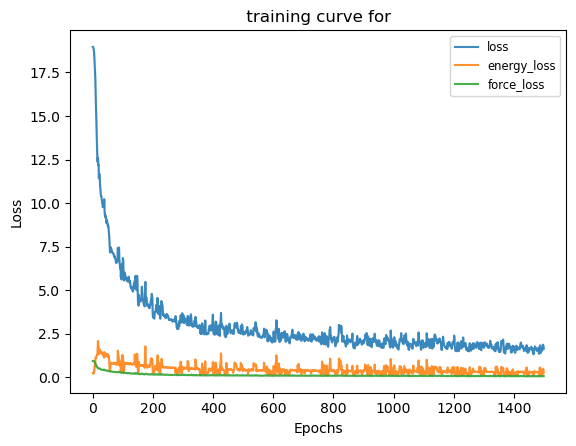

In [16]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [17]:
from kgcnn.moldyn.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange

In [18]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["model_energy"]["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[SetRange(node_coordinates="coords", overwrite=False)],  # To use 
    graph_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, energy="energy", force="forces", atomic_number="nuclear_charges")],
    store_last_input=True,
    update_from_last_input=["range_indices"],  # and "range_images" if periodic.
    update_from_last_input_skip=3    
)

In [19]:
dyn_model(dataset[0:510])[0]

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape:0", shape=(None, 3), dtype=float32), dense_shape=Tensor("gradients/boolean_mask/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


{'energy': array([-17469.55978412]),
 'forces': array([[-2.7271667 ,  2.6897562 , -0.86429495],
        [-0.84712565, -0.87971145,  1.9873401 ],
        [ 3.025331  , -2.1586285 , -0.16754475],
        [-0.40403074,  1.6542995 , -0.05895917],
        [ 0.08988065,  1.8915851 ,  0.8893559 ],
        [-0.5168097 ,  0.2412094 , -0.04888636],
        [ 0.2235128 ,  0.73370975, -2.1159108 ],
        [-0.21408983, -1.4046237 , -0.1606614 ],
        [ 0.47151113,  3.9854836 ,  2.0578196 ],
        [-0.73919386,  1.9803714 ,  0.8280383 ],
        [ 1.1544867 , -1.0601165 ,  0.6265862 ],
        [ 0.5978582 , -3.983492  , -2.131878  ],
        [ 1.6048366 , -0.93785775, -0.6112806 ],
        [-0.24424596, -0.5466848 ,  0.37712604],
        [ 1.2186458 , -1.9348603 ,  1.404673  ],
        [ 0.07340017,  0.35253406, -0.89176875],
        [-1.0534492 ,  0.33991292, -0.16188745],
        [-0.36865112,  0.4609558 , -0.33018097],
        [-0.3471304 , -1.0863894 , -0.70324004],
        [-0.46976444, 

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [20]:
from ase import Atoms
from kgcnn.moldyn.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [21]:
atoms = Atoms(dataset[0]["nuclear_charges"], positions=dataset[0]["coords"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [22]:
conv=AtomsToGraphConverter({"nuclear_charges": "get_atomic_numbers", "coords": "get_positions"})
conv(atoms)

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 2.15275078, -0.93790121, -0.05378575],
       [ 0.99956719,  1.13262738, -1.67300307],
       [ 2.73218273, -0.44859684, -1.19275553],
       [ 2.14794307,  0.41880283, -2.08405233],
       [-3.15705489,  1.42240939,  0.33067654],
       [ 0.91168856, -0.33727827,  0.29772754],
       [ 0.36105629,  0.72618343, -0.42339745],
       [-0.40166094, -0.12259909,  2.26219435],
       [-2.13128849, -0.48888369, -0.80224462],
       [ 0.29867456, -2.24990948,  1.44246368],
       [ 0.1239993 , -0.83296539,  1.42230211],
       [-2.04596577,  0.64616435, -0.22107209],
       [-0.88096468,  1.36265193, -0.06099633],
       [-0.02472582, -2.46371902,  2.33402192],
       [ 2.47956412, -1.70739289,  0.55101985],
       [ 0.49126967,  1.99943374, -2.09234064],
       [ 3.77819263, -0.85891833, -1.40897491],
       [ 2.75656656,  0.58901616, -2.98423316],
       [-2.82095

In [23]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [24]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [25]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

{'energy': array(-17469.55978388), 'forces': array([[-2.7271671 ,  2.6897554 , -0.8642943 ],
       [-0.84712505, -0.87971187,  1.9873402 ],
       [ 3.0253313 , -2.1586287 , -0.16754526],
       [-0.40403122,  1.6543001 , -0.05895895],
       [ 0.08988041,  1.8915849 ,  0.8893564 ],
       [-0.51681   ,  0.24120802, -0.04888517],
       [ 0.22351299,  0.7337096 , -2.1159108 ],
       [-0.21408969, -1.4046241 , -0.16066146],
       [ 0.4715111 ,  3.9854832 ,  2.0578191 ],
       [-0.739194  ,  1.9803717 ,  0.8280388 ],
       [ 1.1544874 , -1.0601165 ,  0.6265857 ],
       [ 0.5978588 , -3.9834921 , -2.131878  ],
       [ 1.6048366 , -0.93785834, -0.6112807 ],
       [-0.24424583, -0.54668397,  0.37712526],
       [ 1.2186457 , -1.9348596 ,  1.4046727 ],
       [ 0.0734001 ,  0.3525342 , -0.89176875],
       [-1.0534494 ,  0.3399132 , -0.16188747],
       [-0.3686508 ,  0.46095574, -0.33018094],
       [-0.34713027, -1.0863892 , -0.7032401 ],
       [-0.46976483,  0.3251502 , -0.528972

In [26]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.884eV  Ekin = 0.037eV (T=285K)  Etot = -831.847eV


Energy per atom: Epot = -831.894eV  Ekin = 0.053eV (T=408K)  Etot = -831.841eV
Energy per atom: Epot = -831.904eV  Ekin = 0.057eV (T=442K)  Etot = -831.847eV
Energy per atom: Epot = -831.893eV  Ekin = 0.047eV (T=362K)  Etot = -831.846eV
Energy per atom: Epot = -831.885eV  Ekin = 0.046eV (T=357K)  Etot = -831.839eV
Energy per atom: Epot = -831.892eV  Ekin = 0.054eV (T=419K)  Etot = -831.838eV
Energy per atom: Epot = -831.898eV  Ekin = 0.055eV (T=425K)  Etot = -831.844eV
Energy per atom: Epot = -831.908eV  Ekin = 0.064eV (T=497K)  Etot = -831.843eV
Energy per atom: Epot = -831.891eV  Ekin = 0.055eV (T=427K)  Etot = -831.836eV
Energy per atom: Epot = -831.880eV  Ekin = 0.045eV (T=345K)  Etot = -831.836eV
Energy per atom: Epot = -831.897eV  Ekin = 0.050eV (T=389K)  Etot = -831.847eV
Energy per atom: Epot = -831.888eV  Ekin = 0.042eV (T=326K)  Etot = -831.846eV
Energy per atom: Epot = -831.899eV  Ekin = 0.052eV (T=401K)  Etot = -831.847eV
Energy per atom: Epot = -831.892eV  Ekin = 0.051eV (

In [27]:
calc.model_predictor._last_input

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 2.36168689, -0.91778404, -0.54048251],
       [ 1.56201305,  1.46628077, -1.89519683],
       [ 3.03375553, -0.46275129, -1.73064512],
       [ 2.55873108,  0.67702342, -2.44364661],
       [-2.57885896,  1.71750008,  0.18801832],
       [ 1.28561023, -0.10996216,  0.00963008],
       [ 0.97187499,  1.06133557, -0.68401192],
       [-0.30146166, -0.05877947,  1.82787946],
       [-1.52732034, -0.0040773 , -1.03006124],
       [ 1.0195855 , -1.85569799,  1.4980243 ],
       [ 0.5829688 , -0.63605587,  1.20820736],
       [-1.40191546,  1.04158508, -0.51746267],
       [-0.15931555,  1.76844559, -0.27350284],
       [ 0.67076521, -1.95174579,  2.42083043],
       [ 2.71972516, -1.77735989,  0.15009216],
       [ 1.2415388 ,  2.23825382, -2.66457354],
       [ 3.87299563, -0.9580828 , -2.20242736],
       [ 2.87785897,  0.98402116, -3.46883406],
       [-2.61306